### Setup

---


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score

import pickle
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

from ml_project_2_mlp import utils

### Load Data

---


In [3]:
# Load categories.json from data/crowdsourced
with open("../data/crowdsourced/raw/categories.json") as f:
    categories = json.load(f)

# Load labeled.csv from data/crowdsourced
labeled = pd.read_csv("../data/crowdsourced/raw/labeled.csv")

# Load the website content from data/crowdsourced from pickle
with open("../data/crowdsourced/processed/content.pkl", "rb") as f:
    content = pickle.load(f)

### Crowdsourced Data: Labeling Analysis

---


Let's start with some basic EDA:


In [4]:
print(f"Task title: {labeled['Title'][0]}")
print(f"Task description: {labeled['Description'][0]}")
print(f"Task reward: {labeled['Reward'][0]}")

Task title: Select all categories that are relevant for the website (English websites)
Task description: Given a screenshot, title, and description of a website, select all the relevant categories.
Task reward: $0.10


In [5]:
# Number of records per unique page
number_of_labels, count = np.unique(
    labeled["Input.uid"].value_counts(), return_counts=True
)
for numlabels, c in zip(number_of_labels, count):
    print(f"There are {c} websites each annotated by {numlabels} labelers")

# Show the unique responses for each question
answers = set()
for answer in labeled["Answer.taskAnswers"]:
    parsed_answer = json.loads(answer)
    answers.update([v for v in parsed_answer[0].values() if type(v) == str])
print(f"There are {len(answers)} unique responses: {answers}")

# Average number of labels per user
avg_user_labels = labeled["WorkerId"].value_counts().mean()
print(f"On average each labeler annotated {avg_user_labels} pages")

There are 840 websites each annotated by 3 labelers
There are 3 unique responses: {'NO', 'YES', 'UNSURE'}
On average each labeler annotated 60.0 pages


In [6]:
# Make sure that for all records, AssignmentStatus is Approved
assert (
    len(labeled["AssignmentStatus"].unique()) == 1
    and labeled["AssignmentStatus"].unique()[0] == "Approved"
), "AssignmentStatus is not Approved"
print("✅ All records have AssignmentStatus Approved")

# Confirm that all pages are assigned with at most 3 assignments
max_assignments, count = np.unique(
    labeled["MaxAssignments"], return_counts=True)
assert len(
    max_assignments) == 1 and max_assignments[0] == 3, "MaxAssignments is not 3"
print("✅ This checks with the max assignments allowed.")


# Get Double Check that the list in TaskAnswers is of length 1 always
answers = set()
total = 0
for answer in labeled["Answer.taskAnswers"]:
    parsed_answer = json.loads(answer)
    if len(parsed_answer) > 1:
        total += 1
if total > 0:
    print(f"❗️ There are {total} records with taskAnswers list length > 1")
else:
    print("✅ All records has taskAnswers list length = 1")

# Check missing values for Input.url, Input.screenshot, Input.title, Input.description, report in percentage
for col in ["Input.url", "Input.screenshot", "Input.title", "Input.description"]:
    miss_vals = labeled[col].isna().sum() / len(labeled) * 100
    if miss_vals > 0:
        print(f"❗️ {col} has {miss_vals:.2f}% missing values")

✅ All records have AssignmentStatus Approved
✅ This checks with the max assignments allowed.
✅ All records has taskAnswers list length = 1
❗️ Input.title has 2.86% missing values
❗️ Input.description has 46.19% missing values


Next, let's one hot encode the column `Answer.taskAnswers` based on the
dictionary that each row includes:


In [7]:
# Create idx2cat and cat2idx mappings
idx2cat = {idx: categories[idx]["name"] for idx in categories}
cat2idx = {categories[idx]["name"]: idx for idx in categories}

# Create a new column AnswersParsed
labeled["AnswersParsed"] = labeled["Answer.taskAnswers"].apply(
    lambda x: {
        k.split("-")[-1]: v for k, v in json.loads(x)[0].items() if type(v) == str
    }
)

# Obtain the selected Idx and corresponding categories
labeled["SelectedIdx"] = labeled["AnswersParsed"].apply(
    lambda x: [k for k, v in x.items() if v == "YES"]
)
labeled["SelectedCategories"] = labeled["SelectedIdx"].apply(
    lambda x: [idx2cat[idx] for idx in x]
)

# Now, let's one hot encode the selected categories
for cat in cat2idx:
    labeled[cat] = labeled["SelectedCategories"].apply(
        lambda x: 1 if cat in x else 0)

relevant_columns = ["Input.uid", "Input.url"] + list(cat2idx)
labeled = labeled[relevant_columns]
labeled.head()

,Input.uid,Input.url,Arts,Business,Computers,Games,Health,Home,Kids_and_Teens,News,Recreation,Reference,Science,Shopping,Society,Sports
0,1161124,www.pointlesssites.com,0,0,1,1,0,1,1,0,1,0,0,0,0,0
1,1161124,www.pointlesssites.com,0,0,0,1,0,1,1,0,1,0,0,0,1,0
2,1161124,www.pointlesssites.com,1,0,1,0,0,0,0,0,1,0,0,0,0,0
3,1081241,www.connecticutplastics.com,0,1,1,0,1,0,0,0,0,0,1,0,0,0
4,1081241,www.connecticutplastics.com,0,0,0,0,1,0,0,0,0,0,0,0,0,0


Now, for each website and category, we want to look at the aggreement accross
annotators.


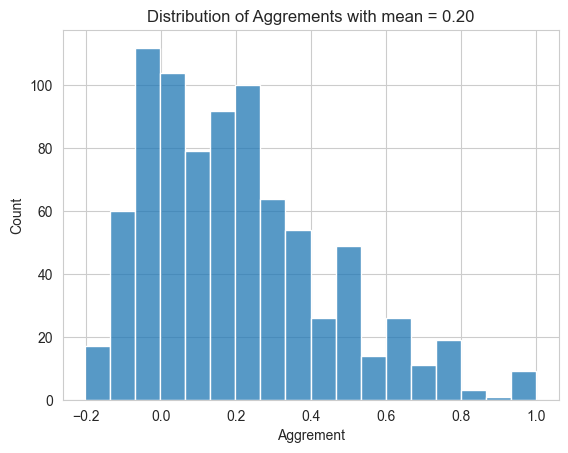

In [8]:
website_ids = labeled["Input.uid"].unique()
aggrements = []
for wid in website_ids:
    # Get all the annotations for this website
    annotations = labeled[labeled["Input.uid"] == wid].iloc[:, 2:].to_numpy()

    # Pair the annotations
    kappas = []
    for i in range(len(annotations)):
        for j in range(i + 1, len(annotations)):
            kappas.append(cohen_kappa_score(annotations[i], annotations[j]))

    # Take the average of all the kappas
    avg_kappa = np.mean(kappas)

    # If nan, then set to 0
    if np.isnan(avg_kappa):
        avg_kappa = 0

    # Save the average kappa for this website
    aggrements.append([wid, avg_kappa])

# Turn into pandas dataframe
aggrements = pd.DataFrame(aggrements, columns=["Input.uid", "Aggrement"])

# Plot the distribution of aggrements
sns.histplot(aggrements["Aggrement"])
plt.title(
    "Distribution of Aggrements with mean = {:.2f}".format(
        aggrements["Aggrement"].mean()
    )
);

Next, let's use different aggregation strategies to obtain final labels for each
webpage:


For threshold = 1, the mean number of categories per website is 6.19
For threshold = 2, the mean number of categories per website is 1.67
For threshold = 3, the mean number of categories per website is 0.28


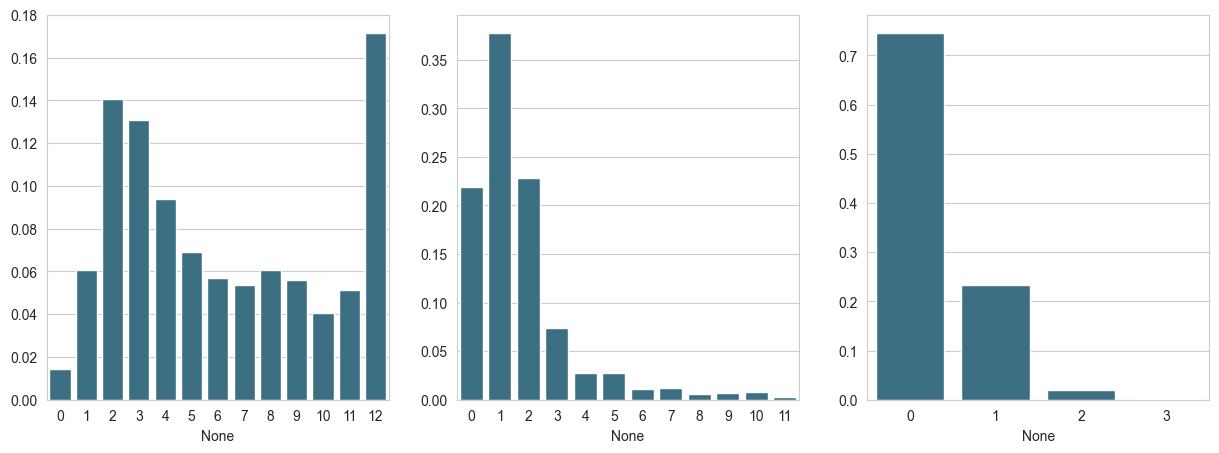

In [9]:
# Compute for each website the number of times the website was assigned given label
page_labc = labeled.groupby("Input.uid").sum()

# For each website, decided whether it belongs to the category or not based on the threshold = min. number of annotations
thresholds = [1, 2, 3]
thresholded = []
for t in thresholds:
    thresholded.append((page_labc.iloc[:, 3:] >= t).astype(int))

# Show the distribution of the number of categories per website
numlab_dist = [thresholded[t - 1].sum(axis=1) for t in thresholds]
print(
    f"For threshold = 1, the mean number of categories per website is {numlab_dist[0].mean():.2f}"
)
print(
    f"For threshold = 2, the mean number of categories per website is {numlab_dist[1].mean():.2f}"
)
print(
    f"For threshold = 3, the mean number of categories per website is {numlab_dist[2].mean():.2f}"
)

# Print the distribution of the number of categories per website
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    sns.barplot(
        x=numlab_dist[i].value_counts().index,
        y=numlab_dist[i].value_counts().values / numlab_dist[i].shape[0],
        ax=ax,
        color="#31748f",
    )

### Crowdsourced Data: Content Analysis

---

In this section, we look closer into what the annotators actually had to label.

In [10]:
# Turn the list of dict into a dataframe
content_df = pd.DataFrame(content)

# Fill Nan in is_valid with False
content_df["is_valid"].fillna(False, inplace=True)

content_df.head()

,webid,http_code,is_valid,html,redirect_url,original_url
0,1161124,200.0,True,"\r\n<!DOCTYPE HTML>\r\n<HTML xmlns:fb=""http://...",None,http://www.pointlesssites.com
1,1081241,200.0,True,"<!DOCTYPE html>\n<html lang=""en"">\n<head>\n \...",None,http://www.connecticutplastics.com
2,1162420,200.0,True,"<!doctype html>\n<html lang=""en-US"">\n <head>...",None,http://99percentinvisible.org
3,1146040,200.0,True,"<!DOCTYPE html>\n<html lang=""en"" dir=""ltr"">\n ...",None,http://www.medicaid.gov
4,1117243,200.0,True,"<?xml version=""1.0"" encoding=""UTF-8"" standalon...",None,http://www.graalonline.com


Let's assess how well we were able to parse the data:

In [11]:
print(f"ℹ️ Number of websites in content_df: {content_df.shape[0]}")
print(f"ℹ️ Number of websites with http status code 200: {content_df[content_df['http_code'] == 200].shape[0]}")
print(f"ℹ️ Number of websites with valid websites {content_df[content_df['is_valid']].shape[0]}")
print(f"ℹ️ Number of websites with redirect: {content_df[content_df['redirect_url'].notna()].shape[0]}")

ℹ️ Number of websites in content_df: 840
ℹ️ Number of websites with http status code 200: 769
ℹ️ Number of websites with valid websites 769
ℹ️ Number of websites with redirect: 250


Now, let's dig deeper, first, we start with the distribution of the http codes:

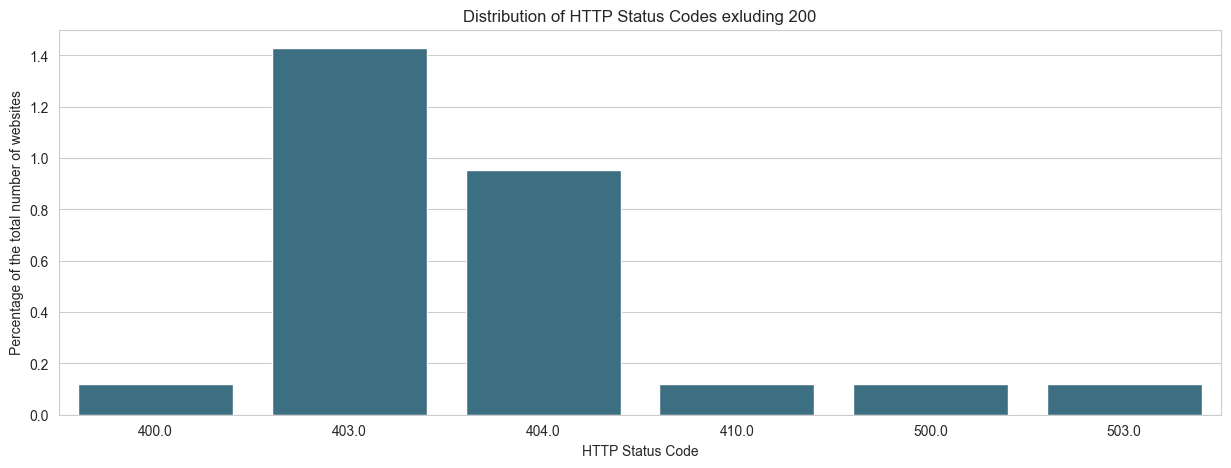

In [12]:
# Setup the figure
fig, ax = plt.subplots(figsize=(15, 5))

# Without 200
sns.barplot(
    x=content_df[content_df["http_code"] != 200]["http_code"].value_counts().index,
    y=content_df[content_df["http_code"] != 200]["http_code"].value_counts().values / content_df.shape[0]*100,
    ax=ax,
    color="#31748f",
);

# Setup the label
ax.set_title("Distribution of HTTP Status Codes exluding 200")
ax.set_xlabel("HTTP Status Code");
ax.set_ylabel("Percentage of the total number of websites");

Next, look at the examples of redirects:

In [13]:
# Get redirect webs
redirect_webs = content_df[content_df["redirect_url"].notna()]

# Randomly sample 5 websites
sampled_webs = redirect_webs.sample(5)

for i, row in sampled_webs.iterrows():
    print(f"ℹ️ {row['original_url']} redirects to {row['redirect_url']}")

ℹ️ http://www.aydon-consultants.com redirects to https://dan.com/buy-domain/aydon-consultants.com?redirected=true
ℹ️ http://www.artcomplex.org redirects to https://artcomplex.org/
ℹ️ http://www.secretsanta.com redirects to https://secretsanta.com/
ℹ️ http://www.precisiontooltech.com redirects to https://precisiontooltech.com/
ℹ️ http://www.ipa.co.ve redirects to https://ipa.co.ve/beta/


It appears that plus or minus the redirects are not an issue since most of the times the difference in the urls is just `/` the slash at the end of the url. Next, let's parse the html of the valid urls:

In [38]:
# Get valid webs
valid_webs = content_df[content_df["is_valid"]].copy()

# Save the features in a dict
web_features = {}

for i in tqdm(range(len(valid_webs))):
    # Get html
    html = valid_webs.iloc[i]['html']

    # Get redirected url if available else original url
    url = valid_webs.iloc[i]['redirect_url'] if valid_webs.iloc[i]['redirect_url'] else valid_webs.iloc[i]['original_url']

    # Get id
    wid = valid_webs.iloc[i]['webid']

    # Get features
    html_features = utils.parse_html(html, max_sentences=100)
    url_features = utils.parse_url(url)
    features = {**html_features, **url_features}

    # Save the features
    web_features[wid] = features

100%|██████████| 769/769 [00:29<00:00, 26.28it/s]


Select random url and shows its extractred features:

In [60]:
# Get random sample of 1 website
sampled_web_id = valid_webs.sample(1)['webid'].values[0]

# Get the features of the sampled website
sampled_web_features = web_features[sampled_web_id]

# Print the features
for k, v in sampled_web_features.items():
    print(f"ℹ️ {k}: {v}")

ℹ️ title: DTELS  Home Page
ℹ️ description: DTELS website devoted to the history of the Directorate of Telecommunications,  Police & Fire Radio Communications
ℹ️ keywords: None
ℹ️ links: ['index.html', 'html', 'about', 'dtels.html', 'html', 'dtels', 'forum.html', 'html', 'feedback.html', 'html', 'image', 'library.html', 'html', 'legal.html', 'html', 'miscellaneous.html', 'html', 'publications.html', 'html', 'personal', 'recollections.html', 'html', 'post', 'dtels.html', 'html', 'site', 'map.html', 'html', 'webmaster.html', 'html', 'legal.html', 'html', 'web', 'site.html', 'html', 'bishops', 'cleeve.html', 'forum', 'viewtopic.php', 't', 'html', 'publications', '.html', 'html', 'radio', 'test', 'area.html', 'html', 'feedback.html', 'forum', 'viewforum.php', 'f', 'html', 'feedback.html', 'html', 'feedback.html', 'html', 'acknowledgements.html']
ℹ️ sentences: ['DTELS - Home Page', 'HOME', 'Cookies Statement:\xa0 some cookies are used on this site and continued browsing assumes you are happy

Now, let's run compute some insights on the extracted features:

In [40]:
# Total number of websites
n = len(web_features)

# Number of sites with title
n_titles = len([title for title in web_features.values() if title['title'] is not None])
print(f"ℹ️ Number of sites with title: {n_titles/n*100:.2f}%")

# Number of sites with description
n_descriptions = len([description for description in web_features.values() if description['description'] is not None])
print(f"ℹ️ Number of sites with description: {n_descriptions/n*100:.2f}%")

# Number of sites with keywords
n_keywords = len([keywords for keywords in web_features.values() if keywords['keywords'] is not None])
print(f"ℹ️ Number of sites with keywords: {n_keywords/n*100:.2f}%")

# Number of sites with links
n_links = len([links for links in web_features.values() if links['links'] is not None])
print(f"ℹ️ Number of sites with links: {n_links/n*100:.2f}%")

ℹ️ Number of sites with title: 98.70%
ℹ️ Number of sites with description: 55.01%
ℹ️ Number of sites with keywords: 19.38%
ℹ️ Number of sites with links: 89.99%


Now, let's look at the distribution of the number of meta tags and the number of links across the websites:

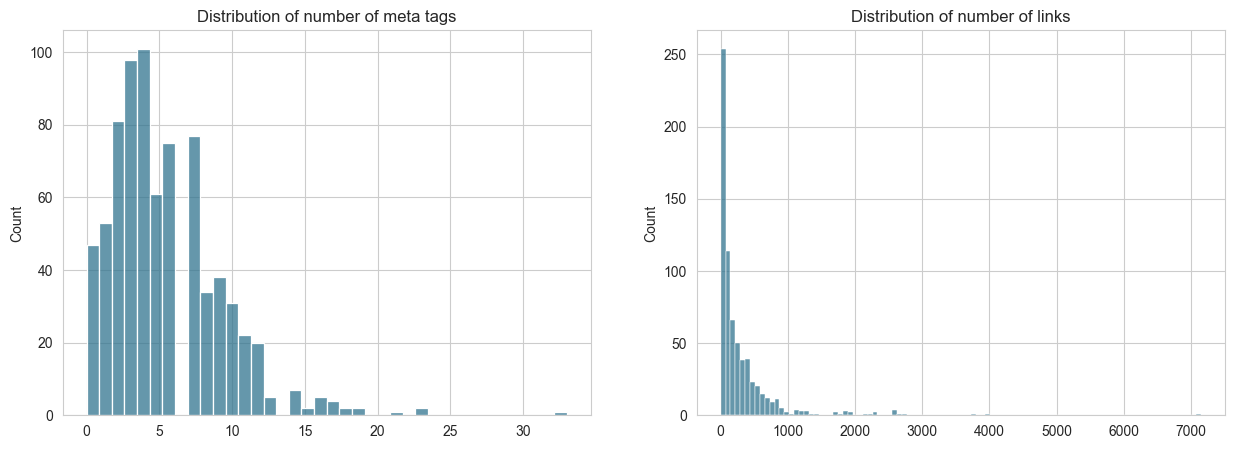

In [49]:
# Get the number of meta tags and links for each website
meta_tags = []
links = []
for features in web_features.values():
    if features['metatags'] is not None:
        meta_tags.append(len(features['metatags']))
    if features['links'] is not None:
        links.append(len(features['links']))

# Setup the figure
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the distribution of meta tags
sns.histplot(meta_tags, ax=axs[0], color="#31748f")
axs[0].set_title("Distribution of number of meta tags")

# Plot the distribution of links
sns.histplot(links, ax=axs[1], color="#31748f")
axs[1].set_title("Distribution of number of links");

Further, let's compute the number of occurences of each meta tag and tld:

In [55]:
# Compute the number of occurrences of each metatag
metatags = {}
tlds = {}
for features in web_features.values():
    if features['metatags'] is not None:
        for metatag in features['metatags']:
            if metatag not in metatags:
                metatags[metatag] = 1
            else:
                metatags[metatag] += 1
    
    if features['tld'] is not None:
            tld = features['tld']
            if tld not in tlds:
                tlds[tld] = 1
            else:
                tlds[tld] += 1


# Sort the metatags by number of occurrences
metatags = {k: v for k, v in sorted(metatags.items(), key=lambda item: item[1], reverse=True)}

# Sort the tlds by number of occurrences
tlds = {k: v for k, v in sorted(tlds.items(), key=lambda item: item[1], reverse=True)}

# Print the top 10 metatags
print("ℹ️ Top 10 metatags:")
for i, (k, v) in enumerate(metatags.items()):
    if i == 10:
        break
    print(f"- {k}: {v/len(web_features)*100:.2f}%")

print()
# Print the top 10 tlds
print("ℹ️ Top 10 tlds:")
for i, (k, v) in enumerate(tlds.items()):
    if i == 10:
        break
    print(f"- {k}: {v/len(web_features)*100:.2f}%")

ℹ️ Top 10 metatags:
- viewport: 73.86%
- description: 59.17%
- robots: 46.55%
- generator: 45.64%
- twitter:card: 35.89%
- keywords: 25.88%
- msapplication-tileimage: 23.28%
- twitter:title: 17.17%
- twitter:description: 14.95%
- google-site-verification: 14.30%

ℹ️ Top 10 tlds:
- com: 60.47%
- org: 16.12%
- co.uk: 4.68%
- net: 3.51%
- edu: 2.60%
- org.uk: 1.69%
- com.au: 1.30%
- de: 1.04%
- blogspot.com: 0.91%
- ca: 0.91%


Finally, let's look into the average number of characters in the sentences:

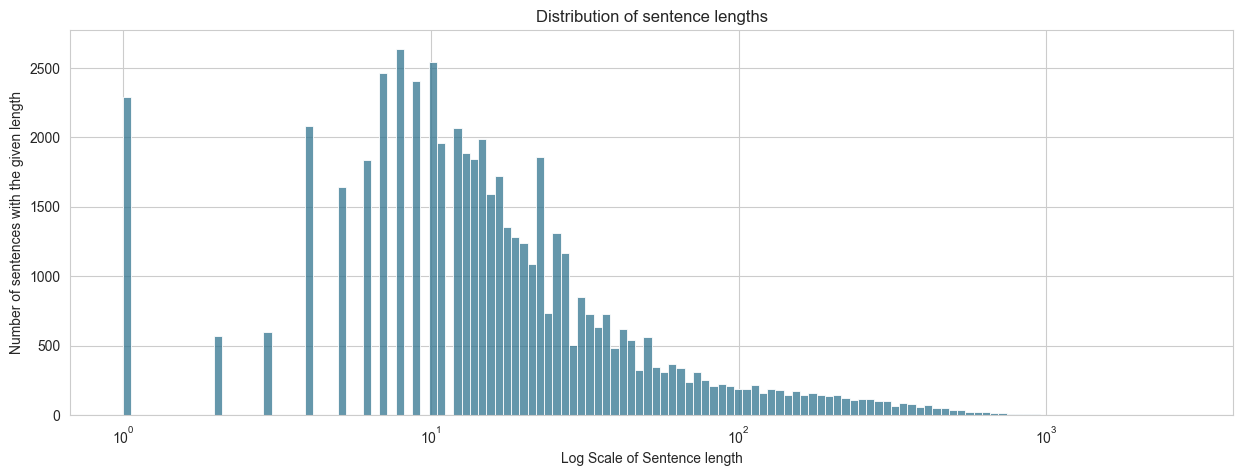

In [59]:
# Compute the number of characters in each sentence
sentence_lengths = []
for features in web_features.values():
    if features['sentences'] is not None:
        for sentence in features['sentences']:
            sentence_lengths.append(len(sentence))

# Setup the figure
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the distribution of sentence lengths
sns.histplot(sentence_lengths, ax=ax, color="#31748f", log_scale=True);

# Add labels
ax.set_title("Distribution of sentence lengths")
ax.set_xlabel("Log Scale of Sentence length")
ax.set_ylabel("Number of sentences with the given length");

---